In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from classifier import *
import features as fe 
import utils as ut
from sklearn.model_selection import train_test_split

In [2]:
def Create_data(Dataset_Size):
    rect = fe.get_rectanges(19, 19)
    no_rect = fe.get_no_rectangles(19, 19)
    X_train_face_img, X_train_nonface_img, X_test_img, y_train_face, y_train_nonface, y_test = ut.get_test_train_data()
    X_train_sub_nonface_img, y_train_sub_nonface = ut.random_subset(X_train_nonface_img, y_train_nonface, len(X_train_face_img))
    assert(len(X_train_face_img) == len(X_train_sub_nonface_img))
    assert(len(y_train_face) == len(y_train_sub_nonface))
    assert(len(X_train_face_img) == len(y_train_face))
    assert(len(X_train_sub_nonface_img) == len(y_train_sub_nonface))

    X_train_img = np.concatenate((X_train_face_img, X_train_sub_nonface_img))
    y_train = np.concatenate((y_train_face, y_train_sub_nonface))

    X_data, y_data = ut.random_subset(X_train_img, y_train, Dataset_Size)
    X_data_fe = fe.par_feature_extraction_images(X_data, rect, no_rect)
    return X_data_fe, y_data
    

def Split_Data(X_data, y_data):
    return train_test_split(X_data, y_data, test_size=0.2)

In [3]:
X, y = Create_data(400)
X_train, X_test, y_train, y_test = Split_Data(X, y)

number_of cpus =  96


### Testing AdaBoost

In [4]:
a = AdaBoostClassifier()
a.fit(X_train, y_train, 2)
print(a.detection_rate(X_test, y_test))
print(a.false_positive_rate(X_test, y_test))

1.0
0.34146341463414637


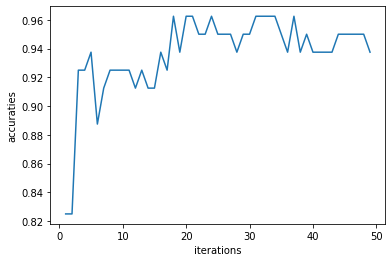

In [5]:
iters = list(range(1, 50))
accuracies = []
dectections = []
false_possitives = []
a = AdaBoostClassifier()
for iter in iters:
    a.fit(X_train, y_train, iter)
    accuracy = a.score(X_test, y_test)
    accuracies.append(accuracy)

plt.xlabel("iterations")
plt.ylabel("accuraties")
plt.plot(iters, accuracies)
plt.show()

In [6]:
def Cascade_Classifier_predict(X_test, y_test, Strong_Classifiers):
    y_preds = []
    for i in range((len(Strong_Classifiers))):
        y_pred = Strong_Classifiers[i].predict(X_test)
        y_preds.append(y_pred)

    ans = np.zeros(len(y_test)) 
    for i in range(len(y_test)):
        is_one = True
        for j in range(len(Strong_Classifiers)):
            if(y_preds[j][i] == 0):
                is_one = False
                break
        if(is_one == True):
            ans[i] = 1
        else:
            ans[i] = 0
    return ans

def Cascade_Classifier_predict_Img(X_test_img, y_test, Strong_Classifiers):
    y_preds = []
    for i in range((len(Strong_Classifiers))):
        y_pred = Strong_Classifiers[i].predict_img(X_test_img)
        y_preds.append(y_pred)

    ans = np.zeros(len(y_test)) 
    for i in range(len(y_test)):
        is_one = True
        for j in range(len(Strong_Classifiers)):
            if(y_preds[j][i] == 0):
                is_one = False
                break
        if(is_one == True):
            ans[i] = 1
        else:
            ans[i] = 0
    return ans

def Cascade_Classifier(X_test,y_test, Strong_Classifiers):
    y_pred = Cascade_Classifier_predict(X_test, y_test, Strong_Classifiers)
    false_positive_rate = np.sum((y_pred == 1) & (y_test == 0))/np.sum(y_test == 0)
    detection_rate = np.sum((y_pred == 1)& (y_test == 1))/np.sum(y_test == 1)
    return false_positive_rate, detection_rate



def Create_validation_sets(X_all, y_all):
    X_train, X_valid, y_train, y_valid = Split_Data(X_all, y_all)
    return X_train, X_valid, y_train, y_valid



def Train_Cascade(X_train_all, y_train_all):    
    F = [0.6]
    D = [0.9]
    f = 0.999
    d = 0.99
    F_target = 0.07
    Threshold_retention = 0.99
    
    F_new = F[-1]
    Strong_Classifiers = []
    no_outermost_loops = 0
    X_train, X_valid, y_train, y_valid = Create_validation_sets(X_train_all, y_train_all)
    while F_new > F_target and no_outermost_loops < 5:
        no_outermost_loops += 1
        a = AdaBoostClassifier()
        F_new = F[-1]

        no_of_features = 0        
        while F_new > f*F[-1] and no_of_features < 50:          #### Hard coded
            no_of_features += 1       
            a.fit(X_train, y_train, no_of_features)
            Strong_Classifiers.append(a)
            F_new, D_new = Cascade_Classifier(X_valid, y_valid, Strong_Classifiers)

            no_innermost_iter = 0
            while(no_innermost_iter < 50):            #### Hard coded
                no_innermost_iter += 1
                a = Strong_Classifiers[-1]
                Strong_Classifiers[-1].threshold = Strong_Classifiers[-1].threshold*Threshold_retention
                F_new, D_new = Cascade_Classifier(X_valid, y_valid, Strong_Classifiers)
                print("L1:", len(Strong_Classifiers), " L2:", no_of_features, " L3:", no_innermost_iter, " F_new: ", F_new, " F_tar:  ", f*F[-1], " D_new:", D_new, "D_expected:", d*D[-1], " Threshold:", a.threshold)
                if D_new > d*D[-1]:       #### Hard coded          
                    break     
                if a.threshold < 1e-10:   #### Hard coded
                    break
                
            Strong_Classifiers.pop()

        F.append(F_new)
        D.append(D_new)
        Strong_Classifiers.append(a)  
        y_pred = a.predict(X_train)
        X_train = X_train[y_pred == 1] 
        y_train = y_train[y_pred == 1]
        if(len(y_train) < 10):
            break
    return Strong_Classifiers



Strong_Classifiers = np.array(Train_Cascade(X_train, y_train))
print("the length of the strong classifiers is", len(Strong_Classifiers))


L1: 1  L2: 1  L3: 1  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 1.0179204481712631
L1: 1  L2: 1  L3: 2  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 1.0077412436895505
L1: 1  L2: 1  L3: 3  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 0.997663831252655
L1: 1  L2: 1  L3: 4  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 0.9876871929401284
L1: 1  L2: 1  L3: 5  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 0.9778103210107271
L1: 1  L2: 1  L3: 6  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 0.9680322178006198
L1: 1  L2: 1  L3: 7  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_expected: 0.891  Threshold: 0.9583518956226136
L1: 1  L2: 1  L3: 8  F_new:  0.21875  F_tar:   0.5993999999999999  D_new: 0.84375 D_

In [7]:
y_pred = Cascade_Classifier_predict(X_test, y_test, Strong_Classifiers)
print("the accuracy of the cascade classifier is", np.sum(y_pred == y_test)/len(y_test))
print("the accuracy of the cascade detection is", np.sum((y_pred == 1) &  (y_test == 1))/sum(y_test == 1))
print("the accuracy of the cascade false postictive is", np.sum((y_pred == 1) & (y_test == 0))/sum(y_test == 0))

the accuracy of the cascade classifier is 0.8875
the accuracy of the cascade detection is 0.8717948717948718
the accuracy of the cascade false postictive is 0.0975609756097561
